In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
print('torch:', torch.__version__)


torch: 2.9.1+cpu


In [8]:

DATA_DIR = "PlantVillage"   
IMAGE_SIZE = 224            
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

Device: cpu


In [9]:

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.14)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
DATA_DIR= r"C:\Users\Ankur\Downloads\PlantVillage"
full_dataset = ImageFolder(root=DATA_DIR, transform=train_transforms)
class_names = full_dataset.classes
num_classes = len(class_names)
print('Classes:', class_names)
print('Total images found:', len(full_dataset))

Classes: ['Healthy', 'Powdery', 'Rust']
Total images found: 150


In [11]:

val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


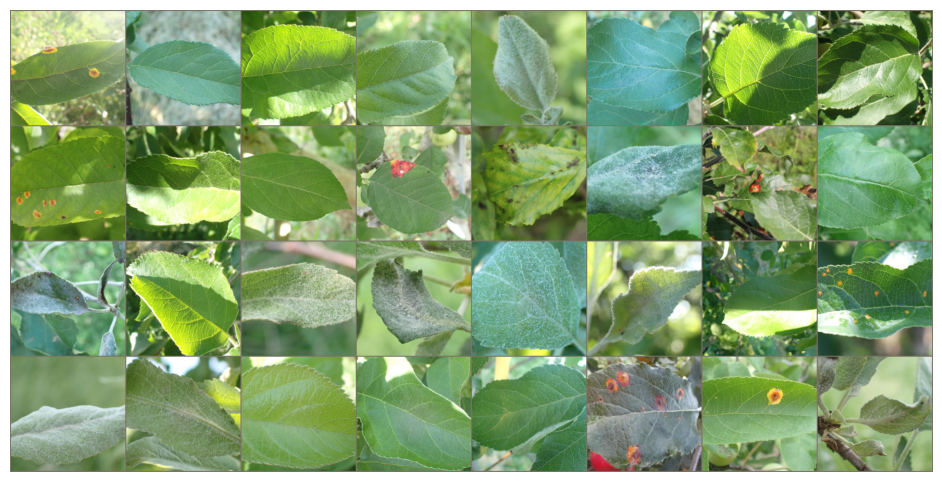

In [12]:

import numpy as np
def imshow_batch(batch, classes):
    imgs, labels = batch
    grid = make_grid(imgs, nrow=8)
    plt.figure(figsize=(12,6))

    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    npimg = grid.cpu().numpy()
    npimg = (np.transpose(npimg, (1,2,0)) * std.numpy().transpose(1,2,0) ) + mean.numpy().transpose(1,2,0)
    plt.imshow(np.clip(npimg,0,1))
    plt.axis('off')

batch = next(iter(train_loader))
imshow_batch(batch, class_names)

In [13]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear((IMAGE_SIZE//8)*(IMAGE_SIZE//8)*128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def create_model(num_classes, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    # replace final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


model = create_model(num_classes=num_classes, pretrained=True)
model = model.to(DEVICE)
print(model)

c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

In [15]:

from tqdm.notebook import tqdm
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    epoch_loss = running_loss / train_size
    epoch_acc = correct / train_size
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_size
    val_acc = val_correct / val_size
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}  Train loss: {epoch_loss:.4f}  Train acc: {epoch_acc:.4f}  Val loss: {val_loss:.4f}  Val acc: {val_acc:.4f}')

Epoch 1/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/10  Train loss: 0.6293  Train acc: 0.7167  Val loss: 4.4390  Val acc: 0.5667


Epoch 2/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/10  Train loss: 0.1375  Train acc: 0.9417  Val loss: 1.8154  Val acc: 0.7667


Epoch 3/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/10  Train loss: 0.0428  Train acc: 0.9917  Val loss: 1.7599  Val acc: 0.8667


Epoch 4/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/10  Train loss: 0.0378  Train acc: 0.9833  Val loss: 0.6205  Val acc: 0.9333


Epoch 5/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/10  Train loss: 0.0252  Train acc: 0.9917  Val loss: 0.5283  Val acc: 0.9000


Epoch 6/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/10  Train loss: 0.0903  Train acc: 0.9917  Val loss: 0.3814  Val acc: 0.9000


Epoch 7/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/10  Train loss: 0.0402  Train acc: 0.9750  Val loss: 0.2713  Val acc: 0.9333


Epoch 8/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/10  Train loss: 0.0139  Train acc: 1.0000  Val loss: 0.4821  Val acc: 0.8667


Epoch 9/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/10  Train loss: 0.0401  Train acc: 0.9917  Val loss: 0.1069  Val acc: 0.9667


Epoch 10/10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/10  Train loss: 0.0527  Train acc: 0.9750  Val loss: 0.0852  Val acc: 0.9667


Text(0.5, 1.0, 'Accuracy')

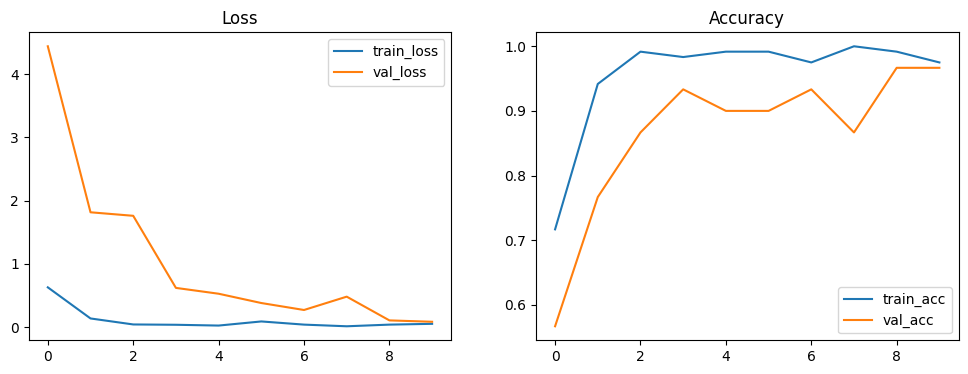

In [16]:

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='train_acc')
plt.plot(val_accs, label='val_acc')
plt.legend()
plt.title('Accuracy')

In [17]:

MODEL_PATH = 'plant_disease_resnet18.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names
}, MODEL_PATH)
print('Saved model to', MODEL_PATH)

Saved model to plant_disease_resnet18.pth


In [19]:

def predict_image(img_path, model, class_names, device=DEVICE):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    transform = val_transforms
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)
        conf, pred = torch.max(probs, 1)
    return class_names[pred.item()], conf.item()

In [ ]:
import gradio as gr
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

# ===============================================
# 1. Load Checkpoint (your trained model)
# ===============================================
checkpoint = torch.load("plant_disease_resnet18.pth", map_location="cpu")

CLASS_NAMES = checkpoint["class_names"]
num_classes = len(CLASS_NAMES)

# ===============================================
# 2. Create Model (same as notebook)
# ===============================================
def create_model(num_classes, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = create_model(num_classes=num_classes, pretrained=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# ===============================================
# 3. Image Preprocessing
# ===============================================
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ===============================================
# 4. Prediction Function
# ===============================================
def predict(image):
    img = image.convert("RGB")
    x = val_transforms(img).unsqueeze(0)

    with torch.no_grad():
        output = model(x)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    return {
        "Predicted Disease": CLASS_NAMES[pred.item()],
        "Confidence (%)": round(conf.item() * 100, 2)
    }

# ===============================================
# 5. Gradio UI (works INSIDE notebook)
# ===============================================
gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Leaf Image"),
    outputs=gr.JSON(label="Prediction Output"),
    title="🌿 Plant Disease Prediction",
    description="Upload a leaf image and get the disease prediction.",
    allow_flagging="never"
).launch(inline=True, debug=True)


c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\gradio\interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        self.scope, self.receive, self.send
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastapi\applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\Ankur\AppData\Local\Programs\Python\Python313\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.midd